# Chapter 2: Efficient Frontier and Markowitz Portfolio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from pandas_datareader import data 
from datetime import datetime
from scipy.optimize import minimize
import edhec_risk_kit as erk

%load_ext autoreload
%autoreload 2
%matplotlib inline

# using seaborn style (type plt.style.available to see available styles)
plt.style.use("seaborn-pastel")  

/home/rex/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Modern portfolio theory (MPT)

The **Modern portfolio theory (MPT)** is a mathematical framework **for assembling a portfolio of assets such that the expected return is maximized for a given level of volatility**. It is a formalization of **diversification in investing**, i.e., the idea that owning different kinds of financial assets is less risky than owning only one assets. 

### Efficient Frontiers 

In the MPT, the **efficient frontier** is the set of portfolios that can be constructed with the given input assets that have the maximum expected returns for a fixed level of volatility. 

![title](data/efficient_frontier.png)

Hence, suppose that **we have $N > 1$ assets**, and we decide to invest all of our capital in them. Let $\mathbf{w}:=(w_1,\dots,w_N)^T$, with $w_i\in (0,1)$ for all $i=1,\dots,N$, 
be the percentages or the weights of the investments in our portfolio.

Suppose we invest all of our capital, there holds $\sum_{i=1}^N w_i = 1$, and $w_i \ge 0$ (this is a **long-only** strategy).

Let $R_i$ and $R_p$ be the return of asset $i$ and the total return of the portfolio, respectively. 
Likewise, let $\sigma_i$ and $\sigma_p$ be the volatility of asset $i$ and the volatility of the portfolio, respectively. 


### Return of a portfolio
The **total return of the porfolio** is the weigthed sum of the returns of single assets, i.e.,
$$
R_p = \sum_{i=1}^N w_i R_i = \mathbf{w}^T \mathbf{R},
$$
where $\mathbf{R} := (R_1,\dots,R_N)^T$. 



### Volatility of a portfolio

The volatility of the portfolio is then given by:
$$
\sigma_p = \sqrt{ \mathbf{w}^T \Sigma \mathbf{w} }.
$$


### Efficient frontiers of 2-assets portfolios 
In the following, we propose an artificial example in order to see the curve that is drawn by different portfolios which 
are constructed with only $2$ assets with different correlation $\rho_{12}$. 
First of all, we assume to generate $500$ **daily returns** of $2$ assets:

In [2]:
nret             = 500
periods_per_year = 252
risk_free_rate   = 0.0

Then, we set up a value for the means and the volatility of our two artifical assets:

In [3]:
mean_1 = 0.001019
mean_2 = 0.001249
vol_1  = 0.016317
vol_2  = 0.019129

and we set up $6$ correlations of the two assets, and for every fixed correlation, 
we will generate $20$ portfolios by allocating $20$ pairs of weights:

In [4]:
# Correlation goes from 1 (completely correlated) to -1 (conversely correlated)
rhos  = np.linspace(1,-1,num=6) 
ncorr = len(rhos)

# Pairs of weights to be used to construct the portfolios for any given correlation
nweig = 20
w1 = np.linspace(0,1,num=nweig)
w2 = 1 - np.linspace(0,1,num=nweig)
ww = pd.DataFrame( [w1, w2] ).T  

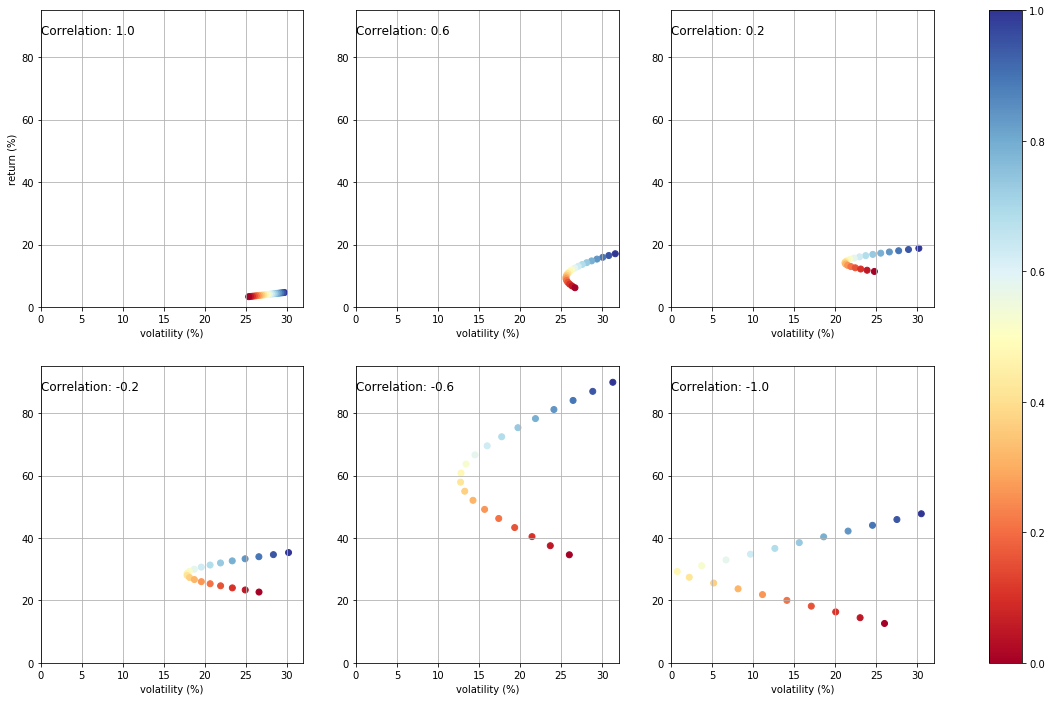

In [5]:
# Set seed
np.random.seed(1)

# Open the figure
fig, ax = plt.subplots(2,3, figsize=(20,12))    
ax = ax.flatten()

for k_rho, rho in enumerate(rhos):
    # Allocate an empty portfolio 
    portfolio = pd.DataFrame(columns=["return","volatility","sharpe ratio"])

    # Generate the assets' returns with the given correlation rho
    cov_ij     = rho * vol_1 * vol_2
    cov_rets   = pd.DataFrame( [[vol_1**2, cov_ij], [cov_ij, vol_2**2]] )
    daily_rets = pd.DataFrame( np.random.multivariate_normal((mean_1,mean_2), cov_rets.values, nret) )
    
    for i in range(ww.shape[0]):
        # Now, construct the portfolio of two asset with correlation rho and weights ww.loc[i]
        weights = ww.loc[i] 
        # here, weights is a column vector (pd.Series)

        # annualized portfolio returns
        ann_rets      = erk.annualize_rets(daily_rets, periods_per_year)
        portfolio_ret = erk.portfolio_return(weights, ann_rets)        
                
        # annualized portfolio volatility
        portfolio_vol = erk.annualize_vol(np.matmul(daily_rets, weights), periods_per_year)

        # annualized portfolio sharpe ratio
        portfolio_spr = erk.sharpe_ratio(np.matmul(daily_rets, weights), risk_free_rate, periods_per_year)

        # dataframe containing the return, volatility, and the sharpe ratio of the portfolio constructed   
        portfolio = portfolio.append( {"return":portfolio_ret, "volatility": portfolio_vol, "sharpe ratio":portfolio_spr}, ignore_index=True)

    # plot create scatter plot coloured by Sharpe Ratio
    im = ax[k_rho].scatter(portfolio["volatility"]*100, portfolio["return"]*100, c=w2, cmap='RdYlBu') 
    ax[k_rho].grid()
    ax[k_rho].set_title("Correlation: {}".format(np.round(rho,2)), y=0.9, loc='left')
    ax[k_rho].set_xlabel("volatility (%)")
    if k_rho==0: ax[k_rho].set_ylabel("return (%)") 
    ax[k_rho].set_xlim([0,32])
    ax[k_rho].set_ylim([0,95])
    
fig.colorbar(im, ax=ax.ravel().tolist())
plt.show()

For any given correlation, each point represents the pair (return, volatility) of a portfolio constructed with some percentage allocation. 
This can be seen in the colorbar: **red corresponds to $\mathbf{w} = (1,0)$**, i.e., allocation of money only to the first asset, whereas 
**blue corresponds to $\mathbf{w} = (0,1)$**, i.e., allocation of money only ot the second asset.  

We can see that **the lower the correlation between the assets, the better the trade-off between return and volatility**: in this example, 
when $\rho=-1$, we could in principle construct a portfolio which guarantee about $30\%$ of return with almost no volatility.

### Example:  French 30 Industry Portfolios 

In [6]:
# Monthly returns of thirty different industry portfolios
ind30 = erk.get_ind_returns()
ind30.head()

Food    Beer   Smoke   Games   Books   Hshld   Clths    Hlth  \
1926-07  0.0056 -0.0519  0.0129  0.0293  0.1097 -0.0048  0.0808  0.0177   
1926-08  0.0259  0.2703  0.0650  0.0055  0.1001 -0.0358 -0.0251  0.0425   
1926-09  0.0116  0.0402  0.0126  0.0658 -0.0099  0.0073 -0.0051  0.0069   
1926-10 -0.0306 -0.0331  0.0106 -0.0476  0.0947 -0.0468  0.0012 -0.0057   
1926-11  0.0635  0.0729  0.0455  0.0166 -0.0580 -0.0054  0.0187  0.0542   

          Chems   Txtls  ...   Telcm   Servs   BusEq   Paper   Trans   Whlsl  \
1926-07  0.0814  0.0039  ...  0.0083  0.0922  0.0206  0.0770  0.0193 -0.2379   
1926-08  0.0550  0.0814  ...  0.0217  0.0202  0.0439 -0.0238  0.0488  0.0539   
1926-09  0.0533  0.0231  ...  0.0241  0.0225  0.0019 -0.0554  0.0005 -0.0787   
1926-10 -0.0476  0.0100  ... -0.0011 -0.0200 -0.0109 -0.0508 -0.0264 -0.1538   
1926-11  0.0520  0.0311  ...  0.0163  0.0377  0.0364  0.0384  0.0160  0.0467   

          Rtail   Meals     Fin   Other  
1926-07  0.0007  0.0187  0.0037  0.0520  
1926-08 -0.0075 -0.0013  0.0446  0.0676  
1926-09  0.0025 -0.0056 -0.0123 -0.0386  
1926-10 -0.0220 -0.0411 -0.0516 -0.0849  
1926-11  0.0652  0.0433  0.0224  0.0400  

[5 rows x 30 columns]

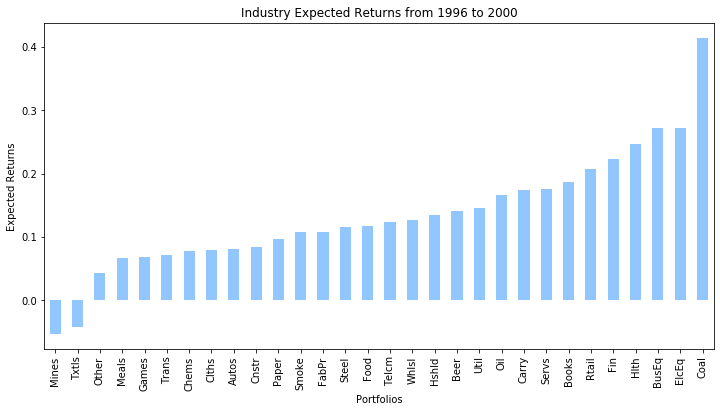

In [7]:
# Get expected returns
er = erk.annualize_rets(ind30['1996':'2000'], 12)
er.sort_values().plot.bar(figsize=(12,6))
plt.xlabel('Portfolios')
plt.ylabel('Expected Returns')
plt.title('Industry Expected Returns from 1996 to 2000');

**Calculate the return and volatility given a set of weights and returns.**

In [8]:
cov = ind30['1996': '2000'].cov()
weights = np.repeat(1/4, 4) # Vector of weights
l = ['Food', 'Beer', 'Smoke', 'Coal'] # Names of the returns
print('Return:', erk.portfolio_return(weights, er[l]))
print('Volatility:', erk.portfolio_vol(weights, cov.loc[l, l]))

Return: 0.19511097196038385
Volatility: 0.055059195776437045


### N Asset Frontier

The objective is to maximize the expected return, and minimize volatility. The function `minimize_vol` in the edhec_risk_kit module takes a set of target returns, the returns from a portfolio, and the covariance matrix for that portfolio and calculates a set of weights for various asset allocations such that the volatility for a particular combination is minimized and the return is maximized. Subsequently, the efficient frontier is plotted using `plot_ef` in the edhec_risk_kit module.

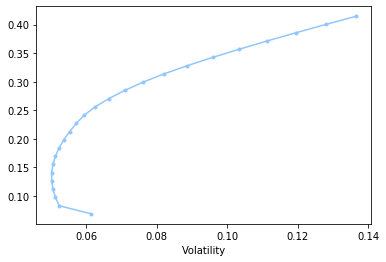

In [9]:
l = ['Smoke', 'Fin', 'Games', 'Coal']
erk.plot_ef(25, er[l], cov.loc[l, l])

## Markowitz Portfolio: CML, MSR, GMV

Recall that a **risk-free asset** is an (hypothetical) asset with a risk-free rate. For example, **short-term government securities (such as US treasury bills)** are used as a risk-free asset since **they pay a fixed interest rate and have exceptionally low default risk**. 

The risk-free asset has zero volatility. Furthermore, it is also uncorrelated with any other asset since, 
by definition, its volatility is zero. Therefore, when combined with any other asset in a portfolio, 
**the change in return is linearly related to the change in risk** as the proportions in the combination vary.

#### The capital market line (CML)

When a risk-free asset is introduced, there will be a line satisfying:

 1. it is tangent to the curve at the risky portfolio with the highest Sharpe ratio; 
 2. its vertical intercept represents a portfolio with $100\%$ of holdings in the risk-free asset; 
 3. the tangency with the curve represents the highest sharpe ratio portfolio with no risk-free holdings and $100%$ of risky assets; 
 assets held in the portfolio occurring at the tangency point; 
 4. points on this line represent portfolios containing positive amounts of both the risky assets and the risk-free asset; 
 
This efficient line is called the **Capital Market Line (CML)**, and its given by:
$$
R_{CML} = R_{f} + \sigma_{CML}\frac{R_{p} - R_{f}}{\sigma_{p}}, 
$$
where $R_p$ and $\sigma_p$ are the return and the volatility of the risky portfolio with no risk free asset, respectively, 
$R_f$ denotes the risk-free rate, and $R_{CML}$ and $\sigma_{CML}$ denote the return and the volatility of the 
portfolio combining both risky assets and the risk-free asset, respectively.

The capital market line (CML) represents portfolios that optimally combine risk and return. Capital asset pricing model (CAPM) depicts the trade-off between risk and return for efficient portfolios. It is a theoretical concept that represents all the portfolios that optimally combine the risk-free rate of return and the market portfolio of risky assets. Under CAPM, all investors will choose a position on the capital market line, in equilibrium, by borrowing or lending at the risk-free rate, since this maximizes return for a given level of risk. The point where the CML is tangent to the efficient frontier is called the Maximum Sharpe Ratio Portfolio.

![title](data/sharpe_portfolio.gif)

Note that the efficient frontier changes shape dramatically when a risk-free asset is introduced.

### Locating the Max Sharpe Ratio (MSR) Portfolio

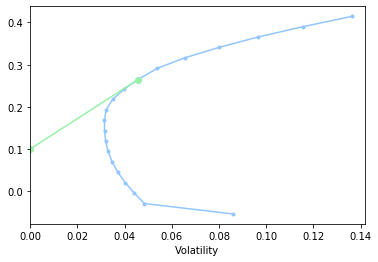

In [10]:
ax = erk.plot_ef(20, er, cov)
plt.gca().set_xlim(left=0)
rf = 0.1
w_msr = erk.msr(rf, er, cov)
r_msr = erk.portfolio_return(w_msr, er)
vol_msr = erk.portfolio_vol(w_msr, cov)
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
plt.gca().plot(cml_x, cml_y, marker='o');

Along the minimum-variance frontier, the left-most point is a portfolio with minimum variance when compared to all possible portfolios of risky assets (shown in red in the plot below). This is known as the global minimum-variance portfolio. An investor cannot hold a portfolio of risky (note: risk-free assets are excluded at this point) assets with a lower risk than the **global minimum-variance (GMV)** portfolio.  

The portion of the minimum-variance curve that lies above and to the right of the global minimum variance portfolio is known as the Markowitz efficient frontier as it contains all portfolios that rational, risk-averse investors would choose.

The function `plot_ef` in the `erk` module allows one to plot the GMV portfolio by setting the `show_gmv` parameter to True and the equal weight portfolio (EW, shown in yellow) by setting `show_ew` to True as well.

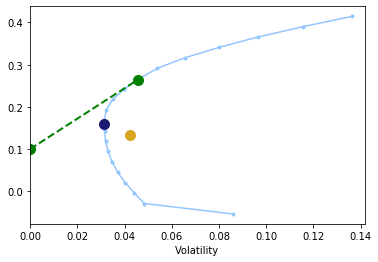

In [11]:
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1, show_ew=True, show_gmv=True);

### Danger of MSR Portfolio

Note that very small differences in the expected returns, which are likely present if we attempt to forecast them, can have a dramatic effect on the asset allocation in a portfolio.

In [12]:
# Calculate the asset allocation for returns in-sample (!)
l = ['Food', 'Steel']
print('Returns:', er[l].round(4).tolist())
print('Portfolio:', erk.msr(0.1, er[l], cov.loc[l, l]).round(4).tolist())

Returns: [0.1168, 0.1158]
Portfolio: [0.7504, 0.2496]


In [13]:
# Attempt to guess the returns
print('Portfolio:', erk.msr(0.1, np.array([0.11, 0.12]), cov.loc[l, l]).round(4).tolist())
print('Portfolio:', erk.msr(0.1, np.array([0.10, 0.13]), cov.loc[l, l]).round(4).tolist())
print('Portfolio:', erk.msr(0.1, np.array([0.13, 0.10]), cov.loc[l, l]).round(4).tolist())

Portfolio: [0.5793, 0.4207]
Portfolio: [0.0, 1.0]
Portfolio: [1.0, 0.0]


### Example from the real world: US stocks
Now we will get the timeseries of some US economy stocks and see how to construct a portfolio in an efficient way.

In [14]:
tickers  = ['AMZN','KO','MSFT']
n_assets = len(tickers) 

stocks = pd.DataFrame()
for stock_name in tickers:
    # daily data
    stocks[stock_name] = data.DataReader(stock_name, data_source="yahoo", 
                                         start=datetime(2010,1,1), end=datetime(2019,11,15))["Adj Close"]    

In [15]:
stocks.tail()

AMZN         KO        MSFT
Date                                          
2019-11-11  1771.650024  50.549065  144.814545
2019-11-12  1778.000000  50.422302  145.766037
2019-11-13  1753.109985  51.104870  146.003906
2019-11-14  1754.599976  51.319393  146.747253
2019-11-15  1739.489990  51.358395  148.640335

In [16]:
# compute the daily returns 
daily_rets = stocks.pct_change().dropna()
daily_rets.tail()

AMZN        KO      MSFT
Date                                    
2019-11-11 -0.007968 -0.007087  0.001028
2019-11-12  0.003584 -0.002508  0.006570
2019-11-13 -0.013999  0.013537  0.001632
2019-11-14  0.000850  0.004198  0.005091
2019-11-15 -0.008612  0.000760  0.012900

In [17]:
# compute the mean daily returns and the covariance of daily returns of the two assets
mean_rets = daily_rets.mean()
std_rets  = daily_rets.std()
cov_rets  = daily_rets.cov()
cov_rets

AMZN        KO      MSFT
AMZN  0.000384  0.000047  0.000138
KO    0.000047  0.000088  0.000050
MSFT  0.000138  0.000050  0.000207

Now we simulate $4000$ portfolios with weights allocated to the stocks above:

In [18]:
periods_per_year = 252
num_portfolios   = 4000
portfolios       = pd.DataFrame(columns=["return","volatility","sharpe ratio","w1","w2","w3"])
risk_free_rate   = 0

In [19]:
for i in range(num_portfolios):
    # select random weights
    weights = np.random.random(n_assets)
    # and rescale them to sum to 1
    weights /= np.sum(weights)
    
    # annualized portfolio returns
    ann_rets      = erk.annualize_rets(daily_rets, periods_per_year)
    portfolio_ret = erk.portfolio_return(weights, ann_rets)        

    # annualized portfolio volatility
    portfolio_vol = erk.annualize_vol(daily_rets @ weights, periods_per_year)

    # annualized portfolio sharpe ratio
    portfolio_spr = erk.sharpe_ratio(daily_rets @ weights, risk_free_rate, periods_per_year)
    
    # create dataframe   
    portfolios = portfolios.append( {"return":portfolio_ret, 
                                     "volatility":portfolio_vol, 
                                     "sharpe ratio":portfolio_spr, 
                                     "w1": weights[0], "w2": weights[1], "w3": weights[2]}, 
                                     ignore_index=True)

Now we create a scatter plot coloured by sharpe ratios of the portfolios generated above and we also plot the efficient frontier:

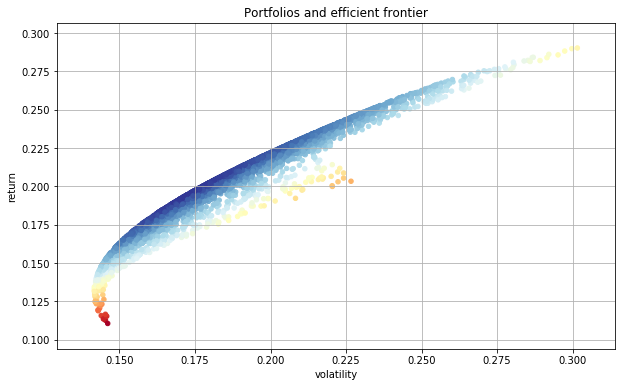

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,6)) 

im = ax.scatter(portfolios["volatility"], portfolios["return"], c=portfolios["sharpe ratio"], s=20, edgecolor=None, cmap='RdYlBu')
ax.set_title("Portfolios and efficient frontier")
ax.set_xlabel("volatility")
ax.set_ylabel("return")
ax.grid()
plt.show()

**We will come back to the plot of the efficient frontier below**.

We can see that if the investor is targeting **a return of $20\%$** he could simply hold 
a portfolio **with volatility of about $17.5\%$**, although there are many other portfolios that 
can guarantee the same return but with much higher volatilities such as $22.5\%$. 
It is clear that one should carefully choose the weights of the portfolio. 

We can see, in particular, that there are **two important** portfolios:

1. the **portfolio with the Global Minimum Volatility (GMV)**, i.e., the global minimum variance portfolio
2. the **portfolio with the Maximum Sharpe Ratio (MSR)**.

From the code above we can easily locate these two portfolios in our dataframe by looking at the lowest volatility and highest sharpe ratio 
and and recover the corresponding weights that have been stored.

In [21]:
# find the portfolio with lowest volatility 
low_vol_portfolio = portfolios.iloc[ portfolios['volatility'].idxmin() ]
print("Global Minimum Volatility portfolio:")
print("- return      : {:.2f}%".format(low_vol_portfolio[0]*100) )
print("- volatility  : {:.2f}%".format(low_vol_portfolio[1]*100) )
print("- sharpe ratio: {:.2f}".format(low_vol_portfolio[2]) )

# find the portfolio with highest sharpe ratio
high_sharpe_portfolio = portfolios.iloc[ portfolios['sharpe ratio'].idxmax() ]
print("\Maximum Sharpe Ratio portfolio:")
print("- return      : {:.2f}%".format(high_sharpe_portfolio[0]*100) )
print("- volatility  : {:.2f}%".format(high_sharpe_portfolio[1]*100) )
print("- sharpe ratio: {:.2f}".format(high_sharpe_portfolio[2]) )

Global Minimum Volatility portfolio:
- return      : 13.15%
- volatility  : 14.17%
- sharpe ratio: 0.96
\Maximum Sharpe Ratio portfolio:
- return      : 19.36%
- volatility  : 17.17%
- sharpe ratio: 1.20


### Finding the optimal portfolios: Global Minimum Volatility Portfolio

In the experiments above, we found the optimal portfolios, i.e., the ones on the efficient frontier, by **simulating a high number of portfolios** and then plotting them. From the plot we could see what the efficient frontier looked like. 
However, we can find an optimal portfolio on the efficient frontier by **solving a minimization problem**, 
for example, by applying the **scipy optimize** method. 


For example, suppose we want to **find the portfolio (on the efficient frontier) which has the minimum volatility**. 
Then the minimization problem is:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$

In [22]:
optimal_weights = erk.gmv(cov_rets)
print("optimal weights:")
print("  AMZN: {:.2f}%".format(optimal_weights[0]*100))
print("  KO:   {:.2f}%".format(optimal_weights[1]*100))
print("  MSFT: {:.2f}%".format(optimal_weights[2]*100))

optimal weights:
  AMZN: 5.46%
  KO:   78.79%
  MSFT: 15.74%


### Finding the optimal portfolios: maximizing the sharpe ratio 

Now, consider the case of finding **the portfolio (on the efficient frontier) with the highest sharpe ratio**. 

Note that scipy offers a **minimize** method, but no a **maximize** a method, and we may then conclude 
that we are not able to find such a portfolio by solving an optimization problem. 
However, **the maximization of the sharpe ratio is nothing but the minimization of the negative sharpe ratio**. 
That is, we have 
$$
\text{minimize} \;\; -  \frac{R_p - r_f}{\sigma_p} =: -\text{SR} 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{1} = 1, \\
0 \leq \mathbf{w} \leq 1.
\end{cases}
$$

Let us use our minimizer:

In [23]:
optimal_weights = erk.msr(risk_free_rate, ann_rets, cov_rets)
print("optimal weights:")
print("  AMZN: {:.2f}%".format(optimal_weights[0]*100))
print("  KO:   {:.2f}%".format(optimal_weights[1]*100))
print("  MSFT: {:.2f}%".format(optimal_weights[2]*100))

optimal weights:
  AMZN: 31.51%
  KO:   39.26%
  MSFT: 29.23%


### Observation on constraints

It is worth mentioning that so far we have decided to invest all of our capital and, at the same time, our strategy has been **long-only**. That is, the weights that we allocate to the assets sum to $1$ 
and all of them are positive (because we **buy** the assets). 
In particular, these two conditions were imposed when solving the minimization problems. 

However, **we could in principle not invest all of our capital**, which means that we at do not necessarily get weights that sum to $1$, and also we may decide to not buy all the assets. We could also **short selling** some of them (by short shelling we mean selling an asset that we do not have and that we borrow from someone else).

#### Short selling and not normalized weigths: minimum volatility portofolio given a fixed return 

We can solve the minimization problem without imposing the constraint on positive weigths and the constraint that the weights sum to $1$, i.e., simply:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{R} = R_0, 
\end{cases}
$$
in the case of finding the minimum volatility portfolio for a fixed return. 
In this case we are allowed to **short sell** the asset and in principle we do not have to invest all of our capital.

For such a problem we can find the analytical solution to the problem by using the **Lagrange multipliers**. 
We define the **Lagrangian** of the problem:
$$
\mathcal{L}(\mathbf{w}, \lambda) := \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w} - \lambda(  \mathbf{w}^T \mathbf{R} - R_0 ),
$$
and put the partial derivatives to zero:
$$
\begin{cases}
\frac{\partial\mathcal{L}}{\partial \mathbf{w}} &= \frac{1}{2} (2\Sigma \mathbf{w}) - \lambda  \mathbf{R} = 0, \\
\frac{\partial\mathcal{L}}{\partial \lambda} &=  - \mathbf{w}^T \mathbf{R} + R_0 = 0.
\end{cases}
$$
From the first equation, we get:
$$
\Sigma \mathbf{w} - \lambda  \mathbf{R} = 0 
\quad\Longrightarrow\quad 
\mathbf{w} = \lambda \Sigma^{-1}\mathbf{R},  
$$
and inserting in the second equation:
$$
- ( \lambda \Sigma^{-1}\mathbf{R} )^T \mathbf{R} + R_0 = 0 
\quad\Longrightarrow\quad 
\lambda \mathbf{R}^T \Sigma^{-1} \mathbf{R} = R_0
\quad\Longrightarrow\quad 
\lambda = \frac{R_0}{\mathbf{R}^T \Sigma^{-1} \mathbf{R}}.
$$
Note that since $\Sigma$ was symmetric, so is $\Sigma^{-1}$, from which $(\Sigma^{-1})^T = \Sigma^{-1}$. 
We can then insert $\lambda$ back into the first equation and obtain:
$$
\mathbf{w}^* = R_0 \frac{\Sigma^{-1}\mathbf{R}}{\mathbf{R}^T \Sigma^{-1} \mathbf{R}},
$$
which is therefore the analytical expression for the weights. Notice that since we have not imposed the constraint 
on the normalisation, we are not guaranteed that such vector of weights sum to $1$. 

#### Short selling and normalized weigths: minimum volatility portofolio given a fixed return 

Analogously, we can also also fin the analytical expression of optimal weights in case we add the condition that the weigths sum to $1$, but without requiring that they have to be all positive, i.e.:
$$
\text{minimize} \;\; \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w}, 
$$
subject to 
$$
\begin{cases}
\mathbf{w}^T \mathbf{R} &= R_0,  \\
\mathbf{w}^T \mathbf{1} &= 1.
\end{cases}
$$
This is again the case in which we can **short sell** the asset but this time we invest all of the capital. 

We define the Lagrangian:
$$
\mathcal{L}(\mathbf{w}, \lambda) := \frac{1}{2} \mathbf{w}^T\Sigma\mathbf{w} 
- \lambda( \mathbf{w}^T \mathbf{R} - R_0) - \delta(\mathbf{w}^T\mathbf{1}-1),
$$
and put the partial derivatives to zero:
$$
\begin{cases}
\frac{\partial\mathcal{L}}{\partial \mathbf{w}} &= \frac{1}{2} (2\Sigma \mathbf{w}) - \lambda \mathbf{R} - \delta \mathbf{1}= 0, \\
\frac{\partial\mathcal{L}}{\partial \lambda} &=  - \mathbf{w}^T \mathbf{R} + R_0 = 0, \\
\frac{\partial\mathcal{L}}{\partial \lambda} &=  - \mathbf{w}^T \mathbf{1} + R_0 = 0.
\end{cases}
$$
From the first equation we get:
$$
\mathbf{w} = \Sigma^{-1}(\lambda \mathbf{R} + \delta\mathbf{1}), 
$$
and we can insert it in the second and the third equation, respectively:
\begin{cases}
\left(\Sigma^{-1}(\lambda \mathbf{R} + \delta\mathbf{1}) \right)^T\mathbf{R} 
&= \lambda \mathbf{R}^T\Sigma^{-1}\mathbf{R} + \delta\mathbf{1}\Sigma^{-1}\mathbf{R} = R_0, \\
\left(\Sigma^{-1}(\lambda \mathbf{R} + \delta\mathbf{1}) \right)^T\mathbf{1} 
&= \lambda \mathbf{R}^T\Sigma^{-1}\mathbf{1} + \delta\mathbf{1}\Sigma^{-1}\mathbf{1} = 1.
\end{cases}
Let us define the following fixed numbers:
$$
\begin{cases}
A & := \mathbf{R}^T \Sigma^{-1} \mathbf{R},  \\
B & := \mathbf{1}^T \Sigma^{-1} \mathbf{R} \equiv \mathbf{R}^T \Sigma^{-1} \mathbf{1}, \\
C & := \mathbf{1}^T \Sigma^{-1} \mathbf{1},
\end{cases}
$$
where notice that in B the second equation is true since $\Sigma^{-1}$ is a symmetric matrix. Hence we have the following system to solve:
$$
\begin{cases}
\lambda A + \delta B &= R_0, \\
\lambda B + \delta C &= 1.
\end{cases}
$$
From the second equation we find $\lambda$ and put it into the first equation:
$$
\lambda = \frac{1-\delta C}{B}
\quad\Longrightarrow\quad 
\frac{1-\delta C}{B} A + \delta B = R_0
\quad\text{from which we find}\quad
\delta = \frac{R_0B - A}{B^2-AC}.
$$
Now, we put $\delta$ back into $\lambda$:
$$
\lambda = \frac{1 - \frac{R_0 B-A}{B^2-AC}C }{B} = \frac{B - R_0 C}{B^2-AC}.
$$
Finally, we can put both $\lambda$ and $\delta$ we have just find back into $\mathbf{w}$ and find the optimal weight:
$$
\mathbf{w}^*  
= \lambda \Sigma^{-1} \mathbf{R} + \delta \Sigma^{-1} \mathbf{1} 
= \frac{B - R_0 C}{B^2-AC} \Sigma^{-1} \mathbf{R}  +  \frac{R_0B - A}{B^2-AC}  \Sigma^{-1}\mathbf{1} 
= \underbrace{ \frac{1}{B^2-AC}\left(B\Sigma^{-1}\mathbf{R} - A\Sigma^{-1}\mathbf{1} \right) }_{:= \mathbf{f} }
+ R_0 \Bigl( \underbrace{ \frac{1}{B^2-AC}\left(B\Sigma^{-1}\mathbf{1} - C\Sigma^{-1}\mathbf{R} \right) }_{:= \mathbf{g} }  \Bigr)
= \mathbf{f} + R_0 \mathbf{g}.
$$